## Outlier Engineering


An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Statistics such as the mean and variance are very susceptible to outliers. In addition, **some Machine Learning models are sensitive to outliers** which may decrease their performance. Thus, depending on which algorithm we wish to train, we often remove outliers from our variables.

In previous notebooks, we discussed how to identify outliers. In this notebook, we will see how we can process them to train our machine learning models.


## How can we pre-process outliers?

- Trimming: remove the outliers from our dataset
- Treat outliers as missing data, and proceed with any missing data imputation technique
- Discrestisation: outliers are placed in border bins together with higher or lower values of the distribution
- Censoring: capping the variable distribution at a max and / or minimum value

**Censoring** is also known as:

- top and bottom coding
- winsorization
- capping


## Trimming or truncation

Trimming, also known as truncation, involves removing the outliers from the dataset. We only need to decide on a metric to determine outliers. As we saw in previously, this can be the Gaussian approximation for normally distributed variables or the inter-quantile range proximity rule for skewed variables.

### Advantages

- quick

### Limitations

- outliers for one variable could contain useful information in the other variables
- if there are outliers across many variables, we could remove a big chunk of dataset

## In this Demo

We will see **how to perform trimming using the Boston House Dataset**

## Important

**Outliers should be detected AND **removed ONLY** from the training set, and NOT from the test set.

**So we should first divide our data set into train and tests, and remove outliers in the train set, but keep those in the test set, and measure how well our model is doing.**

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# boston house dataset for the demo
from sklearn.datasets import load_boston

import warnings
warnings.filterwarnings("ignore")

# Loading the the "Boston House price" data from sklearn

In [4]:
# load the the Boston House price data

# load the boston dataset from sklearn
boston_dataset = load_boston()

# create a dataframe with the independent variables
# I will use only 3 of the total variables for this demo

boston = pd.DataFrame(boston_dataset.data,
                      columns = boston_dataset.feature_names)[['RM', 'LSTAT', 'CRIM']]

boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [5]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RM      506 non-null    float64
 1   LSTAT   506 non-null    float64
 2   CRIM    506 non-null    float64
dtypes: float64(3)
memory usage: 12.0 KB


In [7]:
# A function to check How many columns in a df have unique values with names and count!! 

features = ['RM','LSTAT','CRIM']

for feature in features:
    unique_features = boston[feature].unique()
    num_features = boston[feature].nunique()
    
    if num_features <= 10:
        print('{} has {} values as {}'.format(feature, num_features, unique_features))
    else:
        print('********************************************************')
        print('{} has {} values as {}.....'.format(feature, num_features, unique_features[0:10]))


********************************************************
RM has 446 values as [6.575 6.421 7.185 6.998 7.147 6.43  6.012 6.172 5.631 6.004].....
********************************************************
LSTAT has 455 values as [ 4.98  9.14  4.03  2.94  5.33  5.21 12.43 19.15 29.93 17.1 ].....
********************************************************
CRIM has 504 values as [0.00632 0.02731 0.02729 0.03237 0.06905 0.02985 0.08829 0.14455 0.21124
 0.17004].....


# Function to create histogram, Q-Q plot and boxplot.

In [8]:
# function to create histogram, Q-Q plot and boxplot.

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

## outliers in RM

6.284634387351779


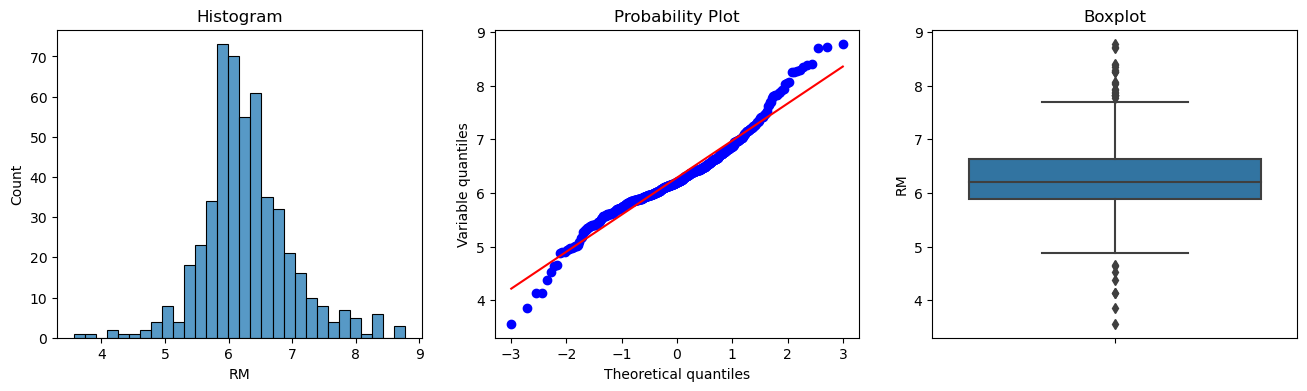

In [10]:
# let's find outliers in RM
print(np.mean(boston['RM']))
diagnostic_plots(boston, 'RM')

## outliers in LSTAT

12.653063241106722


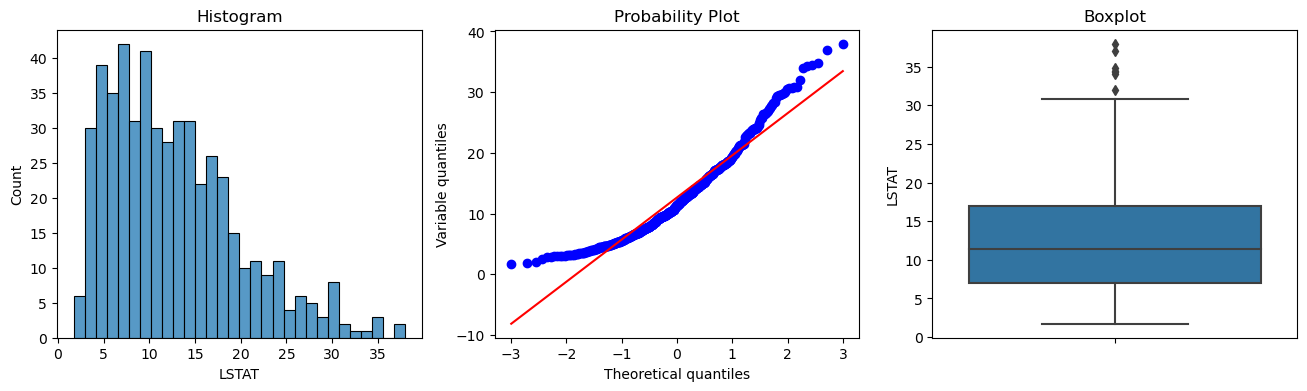

In [11]:
# visualise outliers in LSTAT
print(np.mean(boston['LSTAT']))
diagnostic_plots(boston, 'LSTAT')

## outliers in CRIM

3.613523557312254


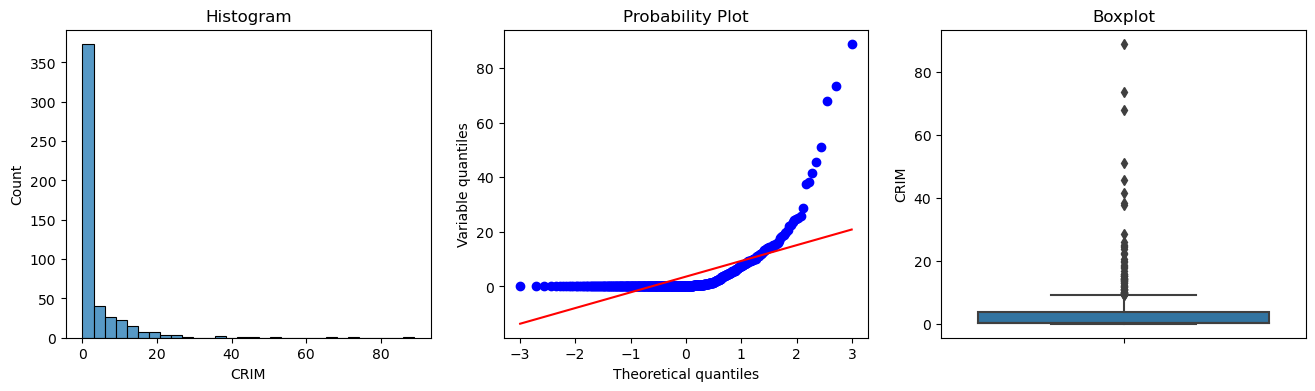

In [12]:
# outliers in CRIM
print(np.mean(boston['CRIM']))
diagnostic_plots(boston, 'CRIM')

**There are outliers in all of the above variables. RM shows outliers in both tails, whereas LSTAT and CRIM only on the right tail.**

# To find the outliers, let's re-utilise the function that we learned for Outlier Detection - 
## "Inter-quantile range proximity rule for Skewed variables"

In [14]:
def find_skewed_boundaries(df, variable, distance):

    # Let's calculate the boundaries outside which sit the outliers for skewed distributions
    # distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)  # Q3 - Q1

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [15]:
# find limits for RM

RM_upper_limit, RM_lower_limit = find_skewed_boundaries(boston, 'RM', 1.5)
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

In [16]:
# limits for LSTAT

LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

(31.962500000000006, -8.057500000000005)

In [17]:
# limits for CRIM

CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

(9.06963875, -5.31051125)

# Flag the outliers in the data set (We will generate Boolean Vector for all 3 variables)

In [18]:
# let's flag the outliers in the data set
# RM
outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))

In [66]:
outliers_RM
# True values are Outliers

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [38]:
len(outliers_RM)

506

In [72]:
from collections import Counter
print(sorted(Counter(outliers_RM).items()))

[(False, 476), (True, 30)]


In [20]:
# let's flag the outliers in the data set
# LSTAT
outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

In [73]:
print(sorted(Counter(outliers_LSTAT).items()))

[(False, 499), (True, 7)]


In [21]:
# let's flag the outliers in the data set
# CRIM
outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

In [74]:
print(sorted(Counter(outliers_CRIM).items()))

[(False, 440), (True, 66)]


# let's trimm the dataset

In [95]:
# let's trimm the dataset

boston_trimmed = boston.loc[~(outliers_RM + outliers_LSTAT + outliers_CRIM)]

boston_trimmed

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905
...,...,...,...
501,6.593,9.67,0.06263
502,6.120,9.08,0.04527
503,6.976,5.64,0.06076
504,6.794,6.48,0.10959


In [96]:
boston.shape, boston_trimmed.shape

((506, 3), (416, 3))

### We can see that using trimming, we removed almost 100 rows, from a dataset of 500 rows, this is about 20% of the data was removed. This is mostly why, we do not tend to use trimming much in machine learning. But if only a few variables present a tiny proportion of outliers, trimming could work.

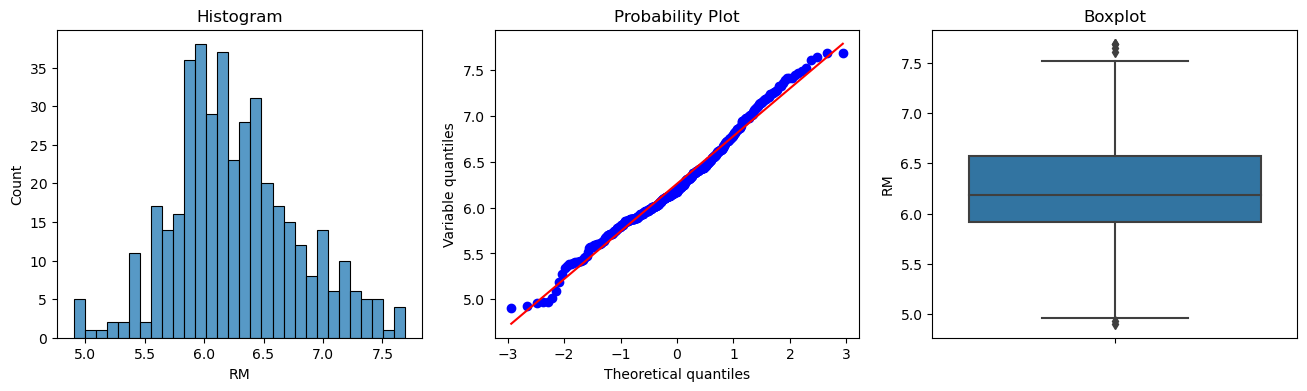

In [97]:
# let's explore outliers in the trimmed dataset
# for RM we see much less outliers as in the original dataset

diagnostic_plots(boston_trimmed, 'RM')

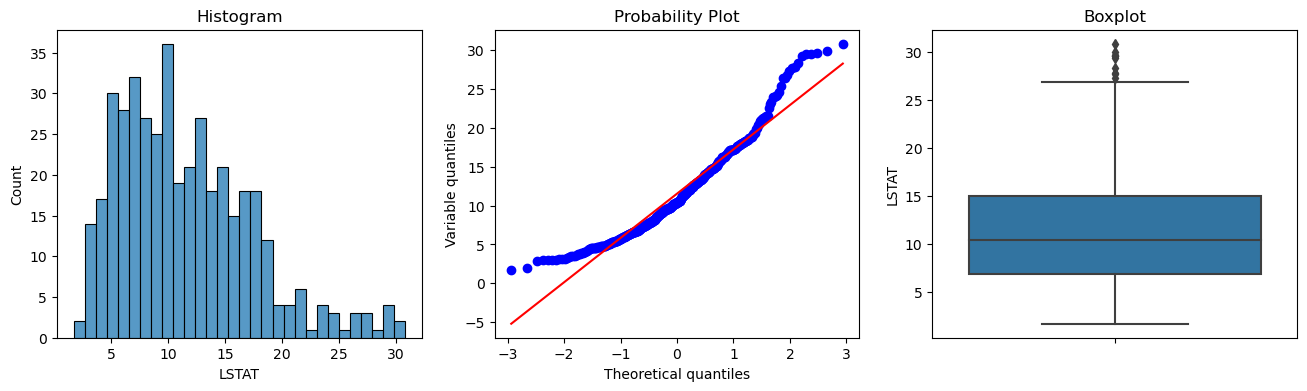

In [26]:
diagnostic_plots(boston_trimmed, 'LSTAT')

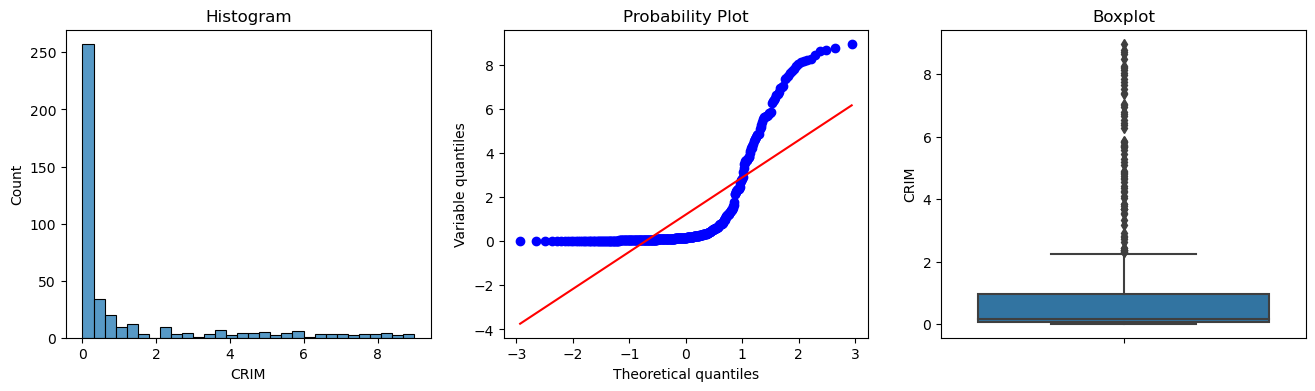

In [27]:
diagnostic_plots(boston_trimmed, 'CRIM')

- **RM we see much less outliers as in the original dataset**

- **For LSTAT and CRIM, we still see many outliers. When we remove data points from our dataset, all the parameters of the distribution are re-calculated, those are the mean, quantiles and inter-quantile range, therefore, in the new -trimmed- variable, values that before were not considered outliers, now are.**

- This is an unwanted characteristic of this way of coping with outliers.
